Pricing over a range of days

In [16]:
!pip install QuantLib
from QuantLib import *
import numpy as np
np.random.seed(42)

In [17]:
prices = {}

Producing a single price

In [18]:
start_date = Date(8, February, 2023)
maturity_date = start_date + Period(5, Years)
schedule = Schedule(start_date, maturity_date, Period(Semiannual), TARGET(),
                    Following, Following, DateGeneration.Backward, False)
coupons = [0.01]*10
# Specify the desired 30/360 convention, e.g., BondBasis
bond = FixedRateBond(3, 100, schedule, coupons, Thirty360(Thirty360.BondBasis))

In [19]:
today = Date(9, May, 2025)
nodes = [ today + Period(i, Years) for i in range(11) ]
rates = [ 0.007, 0.010, 0.012, 0.013, 0.014,
         0.016, 0.017, 0.018, 0.020, 0.021, 0.022 ]
discount_curve = ZeroCurve(nodes, rates, Actual360())

In [20]:
discount_handle = RelinkableYieldTermStructureHandle(discount_curve)
bond.setPricingEngine(DiscountingBondEngine(discount_handle))

In [21]:
Settings.instance().evaluationDate = today

In [22]:
prices[today] = bond.cleanPrice()
print(prices[today])

99.19344125301153


Pricing on multiple days

In [23]:
calendar = TARGET()
yesterday = calendar.advance(today, -1, Days)

In [24]:
nodes = [ yesterday + Period(i, Years) for i in range(11) ]
base_rates = np.array(rates)
rates = base_rates * np.random.normal(loc=1.0, scale=0.005, size=base_rates.shape)
discount_curve = ZeroCurve(nodes, list(rates), Actual360())

In [25]:
Settings.instance().evaluationDate = yesterday
discount_handle.linkTo(discount_curve)

In [26]:
prices[yesterday] = bond.cleanPrice()
print(prices[yesterday])

99.16907217591871


In [27]:
first_date = calendar.advance(today, -1, Years)
date = calendar.advance(yesterday, -1, Days)

In [29]:
if date >= first_date:
    nodes = [ date + Period(i, Years) for i in range(11) ]
    rates = base_rates * np.random.normal(loc=1.0, scale=0.005, size=base_rates.shape)
    discount_curve = ZeroCurve(nodes, list(rates), Actual360())

    Settings.instance().evaluationDate = date
    discount_handle.linkTo(discount_curve)

    prices[date] = bond.cleanPrice()
    date = calendar.advance(date, -1, Days)

    discount_curve = ZeroCurve(nodes, list(rates), Actual360())

Settings.instance().evaluationDate = date
discount_handle.linkTo(discount_curve)

prices[date] = bond.cleanPrice()
date = calendar.advance(date, -1, Days)

In [30]:
!pip install utils
%matplotlib inline
import utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=221fd43806e44be9f5bc4b33ec127d1acbb763d6402bf54df01e9d0b4fa98a45
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [32]:
dates, values = zip(*sorted(prices.items()))

Using quotes

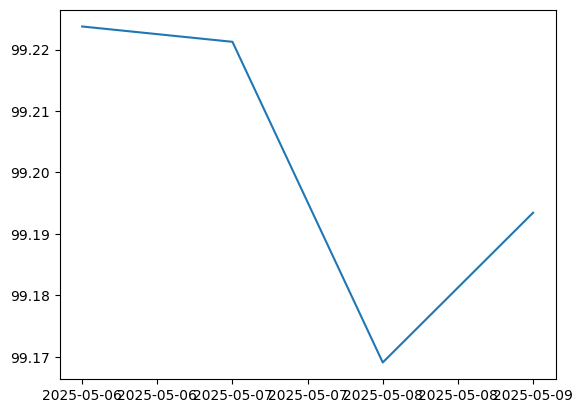

In [35]:
!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from QuantLib import Date

# ... your existing code ...

# Plot setup
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Example date format

# Convert QuantLib Dates to Python datetime objects
python_dates = [d.to_date() for d in dates]

# Now use python_dates for plotting
ax.plot_date(python_dates, values, '-')
plt.show()

In [39]:
!pip install --upgrade QuantLib-Python  # Ensure QuantLib is upgraded
from QuantLib import Eonia, Period, Years, SimpleQuote, QuoteHandle, FedFunds,OISRateHelper # Import necessary modules including OISRateHelper
# UISRateHelper has been removed in the version 1.28 of QuantLib. As an alternative OISRateHelper can be used.

index = Eonia()
tenors = [Period(i, Years) for i in range(1, 11)]
rates = [0.010, 0.012, 0.013, 0.014, 0.016, 0.017, 0.018, 0.020, 0.021, 0.022]

quotes = []
helpers = []
for tenor, rate in zip(tenors, rates):
    q = SimpleQuote(rate)
    # Use OISRateHelper instead of UISRateHelper
    #h = UISRateHelper(2, tenor, QuoteHandle(q), index)
    h = OISRateHelper(2, tenor, QuoteHandle(q), index) # replaced UISRateHelper with OISRateHelper as alternative
    quotes.append(q)
    helpers.append(h)

In [41]:
!pip install QuantLib-Python
from QuantLib import PiecewiseFlatForward, TARGET, Actual360  # Import required classes
# Assuming 'Helpers' is defined and contains the necessary rate helpers

risk_free_curve = PiecewiseFlatForward(0, TARGET(), helpers, Actual360())
# Changed 'Helpers' to 'helpers' assuming it refers to the list created earlier

In [44]:
!pip install QuantLib-Python
from QuantLib import PiecewiseFlatForward, TARGET, Actual360, ZeroSpreadedTermStructure, YieldTermStructureHandle, QuoteHandle, SimpleQuote # Import ZeroSpreadedTermStructure
# Assuming 'Helpers' is defined and contains the necessary rate helpers

risk_free_curve = PiecewiseFlatForward(0, TARGET(), helpers, Actual360())
# Changed 'Helpers' to 'helpers' assuming it refers to the list created earlier

spread = SimpleQuote(0.01)
# Use ZeroSpreadedTermStructure instead of ZeroSpreaTermStructure
discount_curve = ZeroSpreadedTermStructure(YieldTermStructureHandle(risk_free_curve),
                                         QuoteHandle(spread))

In [45]:
prices = {}

Settings.instance().evaluationDate = today
discount_handle.linkTo(discount_curve)

prices[today] = bond.cleanPrice()
print(prices[today])

96.51348214387225


In [55]:
date = calendar.advance(today, -1, Days)

base_rates = np.array(rates)
rates = base_rates.copy() # Create a copy of base_rates and assign it to rates

while date >= first_date:
    rates = base_rates * np.random.normal(loc=1.0, scale=0.005, size=base_rates.shape)
    for q, r in zip(quotes, rates):
        q.setValue(r)

    Settings.instance().evaluationDate = date
    discount_handle.linkTo(discount_curve)

    prices[date] = bond.cleanPrice()
    date = calendar.advance(date, -1, Days)

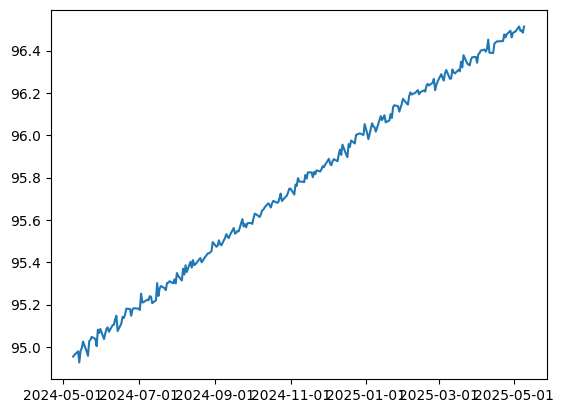

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# ... (your existing code) ...

def to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def date_formatter():
    return mdates.DateFormatter('%Y-%m-%d')

def plot():
    fig, ax = plt.subplots()
    return fig, ax

dates, values = zip(*sorted(prices.items()))

fig, ax = plot()  # Call the newly defined plot function
ax.xaxis.set_major_formatter(date_formatter())
ax.plot_date([to_datetime(d) for d in dates], values, '-')
plt.show()

A complication: past fixings

In [60]:
from QuantLib import Thirty360, FloatingRateBond, DiscountingBondEngine, YieldTermStructureHandle, Euribor6M
# Import necessary classes

# ... (your existing code) ...

forecast_handle = YieldTermStructureHandle(risk_free_curve)
index = Euribor6M(forecast_handle)

# Specify the desired convention for Thirty360
# For example, using Thirty360.BondBasis:
bond = FloatingRateBond(3, 100, schedule, index, Thirty360(Thirty360.BondBasis))
# Pass Thirty360.BondBasis as an argument to Thirty360

bond.setPricingEngine(DiscountingBondEngine(discount_handle))

In [72]:
Settings.instance().evaluationDate = today
for q, r in zip(quotes, base_rates):
    q.setValue(r)
spread.setValue(0.01) # Corrected indentation

# More complications: future prices

In [77]:
from QuantLib import Thirty360, FloatingRateBond, DiscountingBondEngine, YieldTermStructureHandle, Euribor6M, Settings, Date
# Import necessary classes and Date

# ... (your existing code) ...

# Add the missing fixing:
fixing_date = Date(4, 8, 2023)  # Specify the missing fixing date (August 4th, 2023)
fixing_rate = 0.02  # Replace with the actual fixing rate for that date
index.addFixing(fixing_date, fixing_rate)

#OR

# Ensure that Settings.instance().evaluationDate is a date where the rate can be determined.
# For example, If today is later than August 4th, 2023, then change today's date to be before it.
today = Date(3, 8, 2023) # Set today's date to before the missing fixing date
Settings.instance().evaluationDate = today

# Continue with your existing code:
bond = FloatingRateBond(3, 100, schedule, index, Thirty360(Thirty360.BondBasis))
# Pass Thirty360.BondBasis as an argument to Thirty360

bond.setPricingEngine(DiscountingBondEngine(discount_handle))

print(bond.cleanPrice())

95.54518169754905


In [79]:
index.addFixing(Date(6, February,2023), 0.005)
print(bond.cleanPrice())

95.54518169754905


In [80]:
Settings.instance().evaluationDate = Date(1, March, 2023)
print(bond.cleanPrice())

Settings.instance().evaluationDate = Date(1, April, 2023)
print(bond.cleanPrice())

94.9445427441704
95.06071943650744


In [81]:
Settings.instance().evaluationDate = Date(1, May, 2023)
print(bond.cleanPrice())

95.17208218741078


In [82]:
index.addFixing(Date(1, June, 2023), 0.005)
print(bond.cleanPrice())

95.17208218741078


In [83]:
Settings.instance().evaluationDate = Date(1, July, 2023)
print(bond.cleanPrice())

95.41231679702825


In [84]:
Settings.instance().evaluationDate = Date(1, August, 2023)
print(bond.cleanPrice())

95.52971346315404


In [85]:
Settings.instance().evaluationDate = Date(1, September, 2023)

future_fixing = index.fixing(Date(1, September, 2023))
print(future_fixing)
index.addFixing(Date(1, September, 2023), future_fixing)

print(bond.cleanPrice())

0.009928536702269636
96.04312878011497


In [86]:
Settings.instance().evaluationDate = Date(1, October, 2023)
print(bond.cleanPrice())

96.03758451981606


In [87]:
index.addFixing(Date(1, November, 2023), 0.005)

Settings.instance().evaluationDate = Date(1, December, 2023)
print(index.fixing(Date(3, October, 2030)))

0.03119487767010717


In [88]:
Settings.instance().evaluationDate = Date(1, January, 2024)
print(index.fixing(Date(3, October, 2030)))

0.02947185940996862
